In [1]:
import os
import math
import json
import datetime
import numpy as np

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d

def twoDQuadFunc(X, a, b, c, d, e, f):
    return(a*X[0]**2 + b*X[0]*X[1] + c*X[1]**2 + d*X[0] + e*X[1] + f)

class mm_microscope_image:
    '''
    class to store image data collected from micromanager
    '''
    def __init__(self, path):
        self.filepath = path
        self.array = None
        self.framenumber = np.nan
        self.elapsed_time_s = np.nan
        self.channel = np.nan
        self.pixelsizeum = None
        self.md = None
        self.H = None
        self.W = None

        with tifffile.TiffFile(path) as tif:
            try:
                md = json.loads(tif.imagej_metadata["Info"])
                self.md = md
                self.array = tif.asarray()
                self.framenumber = None
                self.elapsed_time_s = md['ElapsedTime-ms']/1000.
                self.channel = None
                try:
                    self.pixelsizeum = md['PixelSize_um']
                except:
                    self.pixelsizeum = md['PixelSizeUm']
                self.H = md['Width']
                self.W = md['Height']
                self.stage_x = md['XPositionUm']
                self.stage_y = md['YPositionUm']
            except:
                self.md = tif.shaped_metadata[0]
                self.array = tif.asarray()
                self.framenumber = None
                self.channel = None
                self.H, self.W = self.md['shape']
                try:
                    self.elapsed_time_s = float(self.md['elapsed_time_s'])
                    self.pixelsizeum = self.md['PixelSizeUm']
                except:
                    pass
                try:
                    self.stage_x = self.md['stage_x_pos']
                    self.stage_y = self.md['stage_y_pos']
                except:
                    pass
    
class led_metadata:
    '''
    class for storing LED timing and intensity data that accompanies some experiment types
    '''
    def __init__(self, path):
        self.filepath = path
        
        
        with open(self.filepath) as f:
            lines = f.readlines()
            summary = lines[0]
            data = lines[1:]

            timestamps = []
            intensities = []

            for i in data:
                timestamp, setstring = i.strip().split('\t')

                intensity = setstring.split(' ')[-1]

                timestamps.append(datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f'))
                intensities.append(int(intensity))
            
            self.timepoints = np.array(timestamps)
            self.ledvalues = np.array(intensities)
            
class mm_acquisition:
    '''
    Class for storting multi-D acqisition data from micromanager
    Also performs background subtraction by estimating a function for background intensity
    '''
    
    def __init__(self, acq_path):
        
        self.acq_path = acq_path
        self.microscope_image_list = []
        
        try:
            with open(acq_path + '/metadata.txt', "r") as read_file:
                self.acq_mdata = json.load(read_file)
        except:
            pass
        
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S.%f')
        except:
            pass
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S')
        except:
            pass
        
        try:
            self.led_data = led_metadata(acq_path + '/intensities.txt')
            self.led_timepoints_sec = [(t - self.start_time).total_seconds() for t in self.led_data.timepoints]
        except:
            pass
            
        for i in np.sort(os.listdir(self.acq_path)):
            
            if ('img' in i) & ('tif' in i):
                try:
                    i = i.decode() # filenames get turned into binary strings sometimes, not sure why
                except:
                    pass

                if '.tif' in i:
                    img_obj = mm_microscope_image(self.acq_path + '/' + i)

                    try:
                        name_fragments = i.split('_')
                        img_obj.framenumber = int(name_fragments[3][4:])
                        img_obj.channel = int(name_fragments[1][7:])

                    except:
                        pass

                    try:
                        img_obj.framenumber = int(self.acq_mdata['Coords-Default/' + i]['Frame'])
                        img_obj.channel = int(self.acq_mdata['Coords-Default/' + i]['ChannelIndex'])
                    except:
                        pass

                    try:
                        img_obj.framenumber = int(self.acq_mdata['Coords-' + i]['time'])
                        img_obj.channel = int(self.acq_mdata['Coords-' + i]['channel'])
                    except:
                        pass


                    self.microscope_image_list.append(img_obj)

        self.channels = np.array([m.channel for m in self.microscope_image_list])
        self.framenumbers = np.array([m.framenumber for m in self.microscope_image_list])
        self.elapsedtimes = np.array([m.elapsed_time_s for m in self.microscope_image_list])
        
        imstack = np.array([m.array for m in self.microscope_image_list])
        
        self.ch0_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch1_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch2_stack = np.zeros((np.nanmax(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        
        for i in self.microscope_image_list:
            if i.channel == 0:
                self.ch0_stack[i.framenumber] = i.array
            if i.channel == 1:
                self.ch1_stack[i.framenumber] = i.array
            if i.channel == 2:
                self.ch2_stack[i.framenumber] = i.array

                
        self.estimate_background()
        self.estimate_stationary_single_cell_signals()
        
    def estimate_background(self):
        img = np.median(self.ch0_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        
        h, w = background.shape
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch0_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch0_stack_bgcorrected = np.array([i.astype(float) - self.ch0_estimated_bg for i in self.ch0_stack])

        img = np.median(self.ch1_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch1_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch1_stack_bgcorrected = np.array([i.astype(float) - self.ch1_estimated_bg for i in self.ch1_stack])
        
    def estimate_stationary_single_cell_signals(self):
        smim = filters.gaussian(self.ch0_stack_bgcorrected[0], 15, preserve_range = True)
        y, x = peak_local_max(smim).T
        D = 10
        within_bounds_filter = (x > D) & (x < 1024 - D) & (y > D) & (y < 1024 - D)
        self.cell_centers_x = x[within_bounds_filter]
        self.cell_centers_y = y[within_bounds_filter]
        
        single_cell_ch0 = []
        single_cell_ch1 = []
        for i in range(len(self.cell_centers_x)):
            xc = int(round(self.cell_centers_x[i]))
            yc = int(round(self.cell_centers_y[i]))

            crop0 = self.ch0_stack_bgcorrected[:, yc - D : yc + D + 1 , xc - D : xc + D + 1]
            crop1 = self.ch1_stack_bgcorrected[:, yc - D : yc + D + 1, xc - D : xc + D + 1]
            
            single_cell_ch0.append(np.average(crop0, axis = (1,2)))
            single_cell_ch1.append(np.average(crop1, axis = (1,2)))
        
        self.single_cell_ch0 = np.array(single_cell_ch0)
        self.single_cell_ch1 = np.array(single_cell_ch1)
        
        baseline_ch0 = np.average(self.single_cell_ch0[:,:5], axis = 1)
        baseline_ch1 = np.average(self.single_cell_ch1[:,:5], axis = 1)
        self.single_cell_ch0_filtered = self.single_cell_ch0[baseline_ch0 >= 200]
        self.single_cell_ch1_filtered = self.single_cell_ch1[baseline_ch1 >= 200]

In [12]:
datafolder = '/Users/jasontown/Desktop/201128_35-52-97-mCherryPAKPBD_twoSpot/'
f = '201128_35-52-97-mCherryPAK_undiff_10uMLatB_twoSpotSwap_6'
filepath = datafolder + f + '/'
mma = mm_acquisition(filepath)
pixum = mma.microscope_image_list[0].pixelsizeum

if (pixum == 0) | (pixum is None):
    pixum = 0.217
    
D = 75
xc = 725
yc = 510

ch0_dynamics = []
ch1_dynamics = []
ch2_dynamics = []

for T in range(len(mma.ch0_stack)):
    
    ch0 = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch1 = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch2 = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D]

    if T == 0:
        smth_ch0 = filters.gaussian(ch0, 2, preserve_range=True)
        bin_ch0 = smth_ch0 > 100
        bin_ch0 = morphology.remove_small_objects(bin_ch0, 100)
        lbl_ch0 = measure.label(bin_ch0)
        reg_ch0 = measure.regionprops(lbl_ch0)
        dist_to_middle = np.array([np.hypot(r.centroid[0] - D, r.centroid[1] - D) for r in reg_ch0])
        lbl_of_interest = reg_ch0[np.argmin(dist_to_middle)].label
        isolated_cell = lbl_ch0 == lbl_of_interest

    smth_ch2 = filters.gaussian(ch2, 2, preserve_range=True)
    bin_ch2 = smth_ch2 > 600

    ch0_dynamics.append(np.average(ch0[isolated_cell]))
    ch1_dynamics.append(np.average(ch1[isolated_cell]))
    ch2_dynamics.append(np.average(ch2[isolated_cell]))

/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2247389282.py:192: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2247389282.py:213: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))


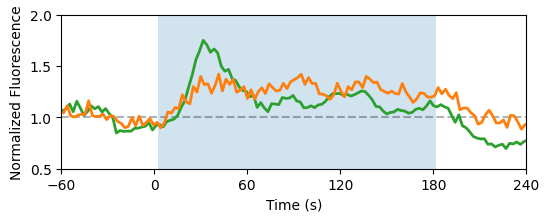

In [13]:
plt.figure(figsize = (6, 2))
plt.axhline(1, ls = '--', color = 'k', alpha = 0.3)
t0 = mma.elapsedtimes[mma.channels == 0] - 60.
plt.plot(t0, ch0_dynamics/np.average(ch0_dynamics[:25]), color = 'C2', lw = 2)
t1 = mma.elapsedtimes[mma.channels == 1] - 60.
plt.plot(t1, ch1_dynamics/np.average(ch1_dynamics[:25]), color = 'C1', lw = 2)
t2 = mma.elapsedtimes[mma.channels == 2] - 60.
plt.fill_between(t2[np.array(ch2_dynamics) > 520], 0, 2, facecolor = 'C0', alpha = 0.2)
plt.ylim(0.5, 2)
plt.xlim(-60, 240)
plt.xticks([-60, 0, 60, 120, 180, 240])
plt.xlabel('Time (s)')
plt.ylabel('Normalized Fluorescence')
plt.show()


/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2860499357.py:13: UserWarning: No contour levels were found within the data range.
  plt.contour(isolated_cell, levels = [False], colors = 'firebrick', linewidths = 0.6, linestyles = '--')
/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2860499357.py:14: UserWarning: No contour levels were found within the data range.
  plt.contour(bin_ch2, levels = [False], colors = 'C0', linewidths = 0.6, linestyles = '--')


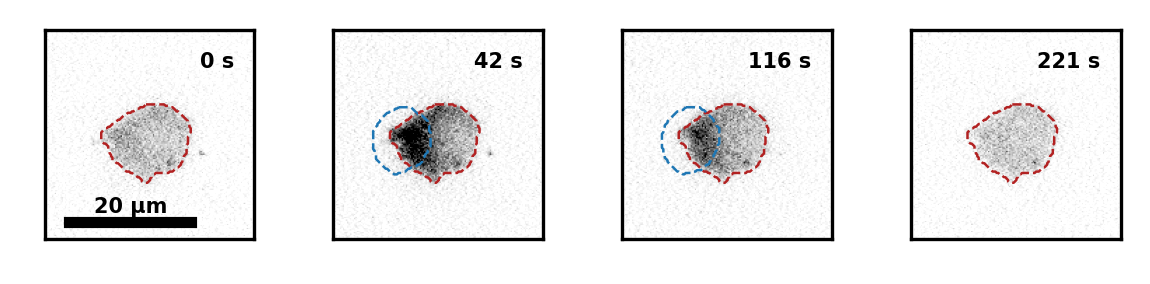

In [14]:
t1 = mma.elapsedtimes[mma.channels == 1] - 60.

plt.figure(figsize = (4, 1), dpi = 300)
for n, T in enumerate([25, 43, 75, 120]):
    ax = plt.subplot(1, 4, n + 1)
    ch0 = mma.ch0_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch1 = mma.ch1_stack_bgcorrected[T][yc-D:yc+D,xc-D:xc+D]
    ch2 = mma.ch2_stack[T][yc-D:yc+D,xc-D:xc+D]
    smth_ch2 = filters.gaussian(ch2, 2, preserve_range=True)
    bin_ch2 = smth_ch2 > 600
    
    plt.imshow(ch0, cmap = 'Greys', vmin = 0, vmax = 400)
    plt.contour(isolated_cell, levels = [False], colors = 'firebrick', linewidths = 0.6, linestyles = '--')
    plt.contour(bin_ch2, levels = [False], colors = 'C0', linewidths = 0.6, linestyles = '--')
    rect = mp.Rectangle((0.2*D, 1.8*D), 20/pixum, 5, color = 'k')
    if n == 0:
        ax.add_patch(rect)
        ax.text(0.2 * D + 10/pixum, 1.78*D, '20 μm', ha = 'center', va = 'bottom', fontweight = 'bold', fontsize = 5)

    timestamp = int(np.round(t1[T], 0))
    ax.text(1.8*D, 0.2*D, str(timestamp) + ' s', ha = 'right', va = 'top', fontsize = 5, fontweight = 'bold')

    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.show()

In [6]:
parent_dir = '/Users/jasontown/Desktop/211013_LocalAdaptation/'
filename = '211012_KWC_35-52-97-mcPAK_undiff_10uMLatB_localAdaptationTest_14/'

mma = mm_acquisition(parent_dir + filename + 'Default/')

/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2247389282.py:192: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2247389282.py:213: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))


/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/3390550481.py:10: UserWarning: No contour levels were found within the data range.
  plt.contour(light_reflected_bin, levels = [False], colors = 'w', linestyles = '--')


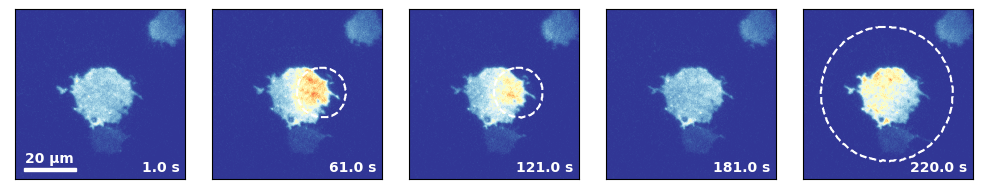

In [7]:
plt.figure(figsize = (10, 2))
for i, t in enumerate([0, 20, 40, 60, 73]):
    et = np.round(mma.elapsedtimes[mma.channels == 0][t])
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(mma.ch0_stack_bgcorrected[t, 400:700, 450:750], vmin = 0, vmax = 5000, cmap = 'RdYlBu_r')
    
    light_reflected_im = mma.ch1_stack_bgcorrected[t, 400:700, 450:750]
    light_reflected_im = filters.gaussian(light_reflected_im, 2, preserve_range = True)
    light_reflected_bin = light_reflected_im > 500
    plt.contour(light_reflected_bin, levels = [False], colors = 'w', linestyles = '--')
    plt.xticks([])
    plt.yticks([])
    
    pix_size = mma.microscope_image_list[0].pixelsizeum
    
    if i == 0:
        scalebar = mp.Rectangle((15, 280), 20/pix_size, 5, color = 'w')
        ax.add_patch(scalebar)
        ax.text(15 + 10/pix_size, 275, '20 µm', ha = 'center', va = 'bottom', fontweight = 'bold', color = 'w')
    
    ax.text(290, 290, str(et) + ' s', ha = 'right', va = 'bottom', fontweight = 'bold', color = 'w')
    
plt.tight_layout()
plt.show()

In [8]:
ALL_L = []
ALL_P = []

for num in [4, 5, 6, 7, 8, 9, 11, 13, 14]:
    print(num)
    parent_dir = '/Users/jasontown/Desktop/211013_LocalAdaptation/'
    filename = '211012_KWC_35-52-97-mcPAK_undiff_10uMLatB_localAdaptationTest_' + str(num) + '/'
    mma = mm_acquisition(parent_dir + filename +  'Default/')
    
    # collect segmentation info (which was done manually in this particular case using napari)
    with tifffile.TiffFile(parent_dir + filename + 'labels.tif') as tif:
        lbl = tif.asarray()
    if len(lbl.shape) == 3:
        lbl = np.max(lbl, axis = 0)
    
    for L in np.unique(lbl):
        if L != 0:
            # crop the image around the cell of interest 
            binim = lbl == L
            cell_props = measure.regionprops(binim.astype(int))[0]
            yc, xc = cell_props.centroid
            xc, yc = int(xc), int(yc)
            yB, xL, yT, xR = cell_props.bbox
            h, w = yT - yB, xR - xL
            D = int(0.8*np.max([h, w]))

            bin_crop = binim[yc-D:yc+D,xc-D:xc+D]
            ch0_crop = mma.ch0_stack_bgcorrected[:,yc-D:yc+D,xc-D:xc+D]
            ch1_crop = mma.ch1_stack_bgcorrected[:,yc-D:yc+D,xc-D:xc+D]
            
            # binarize the reflected light image from channel 1
            light_binary = [filters.gaussian(ch1_crop[T], 2, preserve_range=True) > 2000 for T in range(len(ch1_crop))]
            percent_illum = [np.sum(light_binary[T] & bin_crop)/np.sum(bin_crop) for T in range(len(ch1_crop))]

            # variable between experiments, but determine when the cell was first stimulated
            frame_of_first_stim = np.where(np.array(percent_illum) > 0.1)[0][0]
            startT = mma.elapsedtimes[mma.channels == 0][frame_of_first_stim]
            
            # compare the geometric and weighted centroid of the light intensity image on the segmented cell
            # this gives us the basic coordinate system for the next steps
            reg = measure.regionprops(bin_crop.astype(int), intensity_image=ch1_crop[frame_of_first_stim])[0]
            yc, xc = reg.centroid
            yw, xw = reg.weighted_centroid
            dy, dx = yw - yc, xw - xc
            angle_of_first_stim = np.arctan2(-dy, dx)
            
            # loop over each time point and determine how polarized the rac signal is along the axis
            # of stimulation. We do this by comparing the geometric and fluorescence-weighted centroids
            # and using cosine distances with the angle of stimulation
            polarization = []
            for T in range(len(ch0_crop)):

                reg = measure.regionprops(bin_crop.astype(int), intensity_image=ch0_crop[T])[0]
                yc, xc = reg.centroid
                yw, xw = reg.weighted_centroid
                dy, dx = yw - yc, xw - xc
                angle_relative_to_first_stim =  angle_of_first_stim - np.arctan2(-dy, dx)
                P = np.hypot(dx, dy) * np.cos(angle_relative_to_first_stim)
                T = mma.elapsedtimes[mma.channels == 0][T] - startT
                polarization.append([T,P])

            ALL_P.append(polarization) # probably should have made an experiment-specific class for storing this info
            ALL_L.append(percent_illum)
            
            
    del(mma) # remove the mma object to avoid memory issues on laptop
    

4


/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2247389282.py:192: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
/var/folders/h6/yfxjp1bx4r1bmkqh_nygl6p80000gn/T/ipykernel_57833/2247389282.py:213: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))


5
6
7
8
9
11
13
14


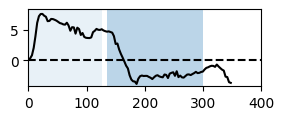

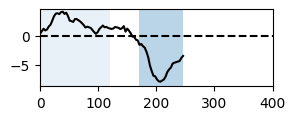

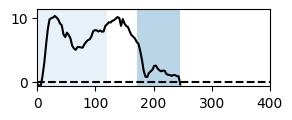

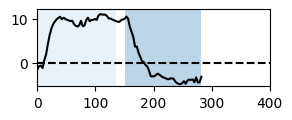

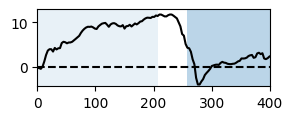

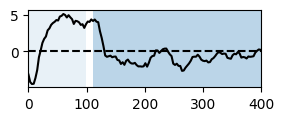

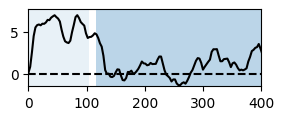

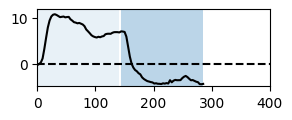

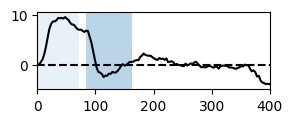

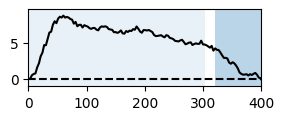

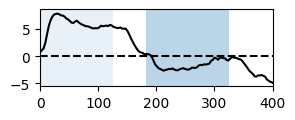

In [9]:
prestim_responses = []
local_responses = []
global_responses = []

for j in range(len(ALL_L)):
    #get frames of first local stim
    i = np.array(ALL_L[j])
    local_stim = ((i > 0.1) & (i < 0.4))
    first_local_stim = measure.label(local_stim) == 1
    end_of_local_stim = np.max(np.where(first_local_stim)[0])
    start_of_local_stim = np.min(np.where(first_local_stim)[0])
    
    global_stim = i > 0.9
    first_postlocal_global_stim = global_stim.copy()
    first_postlocal_global_stim[:end_of_local_stim] = False
    first_postlocal_global_stim = (measure.label(first_postlocal_global_stim) == 1)
    end_of_global_stim = np.max(np.where(first_postlocal_global_stim)[0])
    start_of_global_stim = np.min(np.where(first_postlocal_global_stim)[0])
    
    T = np.array(ALL_P[j])[:,0]
    P = np.array(ALL_P[j])[:,1]
    P_norm = P - np.average(P[:start_of_local_stim])
    T_norm = T - T[start_of_local_stim]
    
    plt.figure(figsize = (3, 1))
    plt.plot(T_norm, P_norm, color = 'k')
    plt.fill_between(T_norm[first_local_stim], -15, 15, facecolor = 'C0', alpha = 0.1)
    plt.fill_between(T_norm[first_postlocal_global_stim], -15, 15, facecolor = 'C0', alpha = 0.3)
    plt.xlim(np.min(T_norm), T_norm[end_of_global_stim])
    plt.ylim(np.min(P_norm) + 0.1*np.min(P_norm), np.max(P_norm) + 0.1 * np.max(P_norm))
    
    prestim_responses.append(P_norm[:start_of_local_stim])
    local_responses.append(P_norm[first_local_stim])
    global_responses.append(P_norm[first_postlocal_global_stim])
    
    plt.axhline(0, ls = '--', color = 'k')
    plt.xlim(0, 400)
    plt.show()

Ttest_1sampResult(statistic=-0.8309572041357751, pvalue=0.42539316815218653)
Ttest_1sampResult(statistic=9.720450405050634, pvalue=2.0600069409104007e-06)
Ttest_1sampResult(statistic=-2.7812792839593277, pvalue=0.01940800892942082)


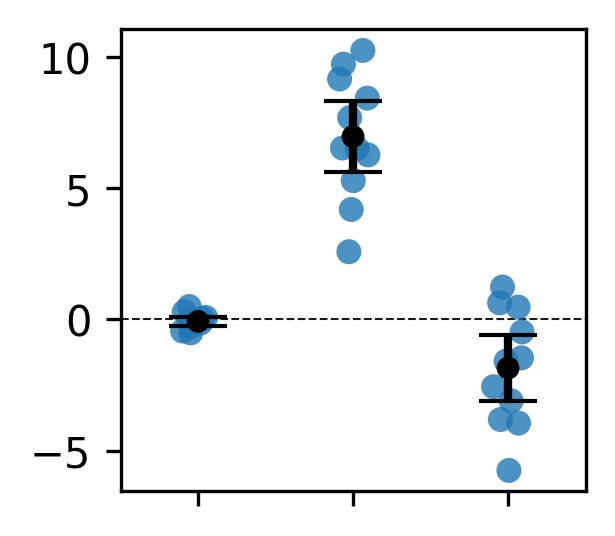

In [10]:

noise = 0.2 # for amount of horizontal jitter in the plot
x0 = np.zeros(len(prestim_responses)) + noise * np.random.random(size = (len(prestim_responses))) - 0.5*noise
y0 = [i[-3] for i in prestim_responses]

x1 = np.zeros(len(local_responses)) + 1 + noise * np.random.random(size = (len(local_responses)))- 0.5*noise
y1 = [i[17] for i in local_responses]

x2 = np.zeros(len(global_responses)) + 2 + noise * np.random.random(size = (len(global_responses))) - 0.5*noise
y2 = [i[17] for i in global_responses]


plt.figure(figsize = (2,2), dpi = 300)
    
plt.scatter(x0, y0, marker = 'o', alpha = 0.8, color = 'C0', ec = 'None')
plt.scatter(x1, y1, marker = 'o', alpha = 0.8, color = 'C0', ec = 'None')
plt.scatter(x2, y2, marker = 'o', alpha = 0.8, color = 'C0', ec = 'None')

xs = [0 - 0.2, 0 + 0.2]
ys = [np.average(y0), np.average(y0)]


xs = [1 - 0.2, 1 + 0.2]
ys = [np.average(y1), np.average(y1)]

xs = [2 - 0.2, 2 + 0.2]
ys = [np.average(y2), np.average(y2)]

CIs = 1.96/np.sqrt(len(y0))*np.array([np.std(y0), np.std(y1), np.std(y2)])
Ym = np.array([np.average(y0), np.average(y1), np.average(y2)])
plt.errorbar(x = [0,1,2], y = Ym, yerr = CIs, color = 'k', linestyle = '', capsize = 7, elinewidth = 2)
plt.scatter([0,1,2], Ym, facecolor = 'k', ec = 'None', s = 30)


plt.xlim(-0.5, 2.5)

plt.axhline(0, ls = '--', color = 'k', alpha = 0.9, zorder = -1, lw = 0.5)

print(stats.ttest_1samp(y0, 0))
print(stats.ttest_1samp(y1, 0))
print(stats.ttest_1samp(y2, 0))
plt.yticks([-5, 0, 5, 10])
plt.xticks([0,1,2], ['','',''])
plt.show()